In [ ]:
import tensorflow as tf
import sklearn as sk
SESS = tf.InteractiveSession()

from models.conv import load_dataset, split_dataset

# Evaluating on test set

In [3]:
VOCAB_SIZE = 4096
PHRASE_LENGTH = 300
data, vocab = load_dataset('data/data.json', PHRASE_LENGTH, 
                           vocab_size=VOCAB_SIZE, retvocab=True)
# drop the training set
_, data = split_dataset(data, test_size=0.2, random_state=np.random.RandomState(314))

In [4]:
saver = tf.train.import_meta_graph('/tmp/tf-checkpoints/words/model.ckpt-0.meta')
saver.restore(SESS, tf.train.latest_checkpoint('/tmp/tf-checkpoints/words/'))

INFO:tensorflow:Restoring parameters from /tmp/tf-checkpoints/words/model.ckpt-1


In [5]:
graph = tf.get_default_graph()
word_idx = graph.get_tensor_by_name('word_idx:0')
phrase_lengths = graph.get_tensor_by_name('phrase_lengths:0')
predict_prob = graph.get_tensor_by_name('prob:0')

(array([ 1350.,   141.,    67.,    38.,    38.,    39.,    43.,    54.,
          124.,   823.]),
 array([  7.25218456e-07,   9.99966592e-02,   1.99992593e-01,
          2.99988527e-01,   3.99984461e-01,   4.99980395e-01,
          5.99976329e-01,   6.99972263e-01,   7.99968197e-01,
          8.99964131e-01,   9.99960065e-01]),
 <a list of 10 Patch objects>)

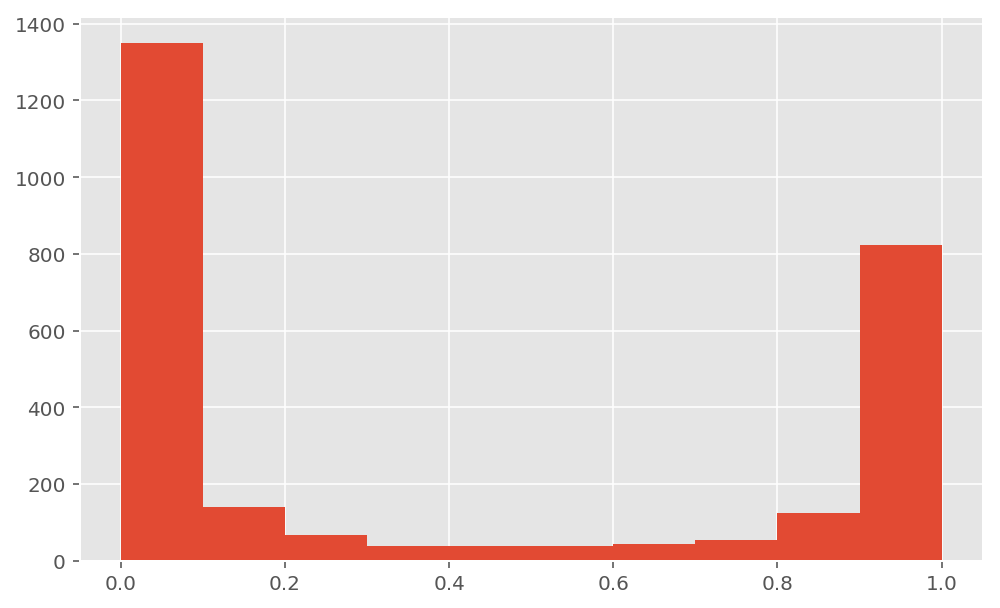

In [6]:
p_pred = SESS.run(predict_prob, feed_dict={word_idx: data.word_idx,
                                           phrase_lengths: data.phrase_lengths})

pl.hist(p_pred)

In [7]:
accuracy = sk.metrics.accuracy_score(data.labels, p_pred > .5)
print(f"Accuracy on training set: {accuracy}")

Accuracy on training set: 0.9407434670592565


In [8]:
sk.metrics.confusion_matrix(data.labels, p_pred > .5)

array([[1556,   83],
       [  78, 1000]])

# Testing it on some real world data:

In [9]:
from preprocess.build_vocab import generate_tokens
from nltk.stem import PorterStemmer

In [10]:
text1 = """The outcomes of quantum mechanical experiments are inherently random. It is therefore
necessary to develop stringent methods for quantifying the degree of statistical uncertainty about 
the results of quantum experiments. For the particularly relevant task of quantum state estimation, 
it has been shown that a significant reduction in uncertainty can be achieved by taking the 
positivity of quantum states into account. However -- the large number of partial results and 
heuristics notwithstanding -- no efficient general algorithm is known that produces an optimal 
uncertainty region from experimental data and the prior constraint of positivity. Here, we make 
this problem precise and show that the general case is NP-hard. Our result leaves room for the 
existence of efficient approximate solutions, and therefore does not yet imply that the practical 
task of quantum uncertainty quantification is intractable. However, it does show that there exists 
a non-trivial trade-off between optimality and computational efficiency for error regions. We 
prove two versions of the result: One for frequentist and one for Bayesian statistics."""

text2 = """Swiss Nanoscience Institute have succeeded in dramatically improving the quality of 
individual photons generated by a quantum system. [23] Physicists from the University of Basel 
have developed a memory that can store photons. [22] Scientists at the University of Sydney are 
entering a new phase of development to scale up the next generation of quantum-engineered devices. 
[21] Engineers at Australia's University of New South Wales have invented a radical new 
architecture for quantum computing, based on novel 'flip-flop qubits', that promises to make 
the large-scale manufacture of quantum chips dramatically cheaper-and easier-than thought 
possible. [20] A team of researchers from the U.S. and Italy has built a quantum memory device 
that is approximately 1000 times smaller than similar devices— small enough to install on a chip. 
[19] The cutting edge of data storage research is working at the level of individual atoms and 
molecules, representing the ultimate limit of technological miniaturisation. [18] This is an 
important clue for our theoretical understanding of optically controlled magnetic data storage 
media. [17] A crystalline material that changes shape in response to light could form the heart 
of novel light-activated devices. [16] Now a team of Penn State electrical engineers have a way 
to simultaneously control diverse optical properties of dielectric waveguides by using a two-layer 
coating, each layer with a near zero thickness and weight. [15] Just like in normal road traffic, 
crossings are indispensable in optical signal processing. In order to avoid collisions, a clear 
traffic rule is required. A new method has now been developed at TU Wien to provide such a rule for 
light signals. [14] """

In [24]:
STEMMER = PorterStemmer()

def word2vec(text, max_len=PHRASE_LENGTH):
    tokens = generate_tokens(text, STEMMER.stem)
    vec = [vocab[token] for token in tokens if token in vocab]
    phrase_length = len(vec)
    word_idx = np.zeros(max_len, dtype=np.int32)
    length = min(max_len, len(vec))
    word_idx[:length] = vec[:length]
    return np.array(word_idx)[None, :], np.array([phrase_length])

def classify(text):
    x, x_len = word2vec(text)
    p = SESS.run(predict_prob, feed_dict={word_idx: x, phrase_lengths: x_len})
    return 'arXiv' if p > .5 else 'viXra'

In [27]:
print(f'Text 1 is from {classify(text1)}.')
print(f'Text 2 is from {classify(text2)}.')

Text 1 is from arXiv.
Text 2 is from viXra.
